In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
from torchsummary import summary

from common_audio import *
from audio_dataset import *

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)


cpu


# Load Dataset

In [9]:
sr = 8000
duration = 5.0
voice_ds = AudioDataSet('datasets/LibriSpeech/LibriSpeech/dev-clean', sr=sr, duration=duration)
# noise_ds = AudioDataSet('datasets/urban/UrbanSound8K/audio', sr=sr, duration=duration)

spectrogram_hw = audio_to_spectrogram(voice_ds.load([0]), sr)[0].shape

In [3]:
# utility
def to_torch(*arrays, device=device, dtype=dtype):
    if len(arrays) == 1:
        array = arrays[0]
        if isinstance(array, np.ndarray):
            array = torch.from_numpy(array)
        return array.to(device, dtype)
    ret = ()
    for array in arrays:
        ret += to_torch(array, device=device, dtype=dtype),
    return ret

def to_np(*arrays):
    if len(arrays) == 1:
        return arrays[0].detach().cpu().numpy()
    ret = ()
    for array in arrays:
        ret += to_np(array),
    return ret

# Model Definitions

In [4]:
def get_block_layer(c_in, c_out, kernel_size=3, padding=1):
    return nn.Sequential(nn.BatchNorm2d(c_in), 
                         nn.ReLU(), 
                         nn.Conv2d(c_in, c_out, kernel_size, padding=padding))
    

class NeuralTransform(nn.Module):
    def __init__(self, c_in, c_out, num_layers, gr):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        
        self.layers = nn.ModuleList()
        
        c_prev = c_in
        for layer_idx in range(num_layers-1):
            self.layers.append(get_block_layer(c_prev, gr))
            c_prev += gr
            
        self.final_layer = get_block_layer(c_prev, c_out)
        
        
    def forward(self, x):
        for layer in self.layers:
            x = torch.cat((x, layer(x)), axis=1)
        x = self.final_layer(x)
        return x
    
def get_down_sample_layer(c, kernel_size=(2,2), stride=(2,2)):
    return nn.Conv2d(c, c, kernel_size=kernel_size, stride=stride)
def get_up_sample_layer(c, kernel_size=(2,2), stride=(2,2)):
    return nn.ConvTranspose2d(c, c, kernel_size=kernel_size, stride=stride)

# frequency time convolutional neural network for generator
class FTCNNGenerator(nn.Module):
    def __init__(self, c_in, cs, c_out=None, num_layers_per_block=4, block_gr=24):
        super().__init__()
        
        if c_out is None:
            c_out = c_in
        
        rcs = list(reversed(cs))
        
        self.conv_first = nn.Conv2d(c_in, cs[0], kernel_size=1)
        self.conv_last = nn.Conv2d(rcs[-1], c_out, kernel_size=1)
        
        self.left = nn.ModuleList([NeuralTransform(c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(cs, cs[1:])])
        self.right = nn.ModuleList([NeuralTransform(2*c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(rcs, rcs[1:])])
        
        self.midnt = NeuralTransform(cs[-1], cs[-1], num_layers_per_block, block_gr)
        
        self.downs = nn.ModuleList([get_down_sample_layer(c) for c in cs[1:]])
        self.ups = nn.ModuleList([get_up_sample_layer(c) for c in rcs[:-1]])
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv_first(x)
        
        residuals = []
        shapes = []
        for nt, down in zip(self.left, self.downs):
            x = nt.forward(x)
            residuals.insert(0, x)
            shapes.insert(0, x.shape)
            x = down(x)
        
        x = self.midnt(x)
        
        for nt, up, residual, shape in zip(self.right, self.ups, residuals, shapes):
            x = up(x, output_size=shape)
            x = torch.cat((x, residual), dim=1)
            x = nt.forward(x)
        
        x = self.conv_last(x)
        return x
    

In [7]:
# frequency time convolutional neural network for discriminator
class FTCNNDiscrimminator(nn.Module):
    def __init__(self, c_in, cs, input_hw, fcs=[100, 10, 10, 1], num_layers_per_block=4, block_gr=24):
        super().__init__()
        
        self.conv_first = nn.Conv2d(c_in, cs[0], kernel_size=1)
        
        self.nts = nn.ModuleList([NeuralTransform(c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(cs, cs[1:])])
        self.dss = nn.ModuleList([get_down_sample_layer(c_out) for c_out in cs[1:]])
        
        h = input_hw[0] // (2**len(self.dss))
        w = input_hw[1] // (2**len(self.dss))
    
        self.fc1d1 = cs[-1]*h*w
            
        fcs.insert(0, self.fc1d1)
        self.fcs = nn.ModuleList([nn.Linear(d1, d2) for d1, d2 in zip(fcs, fcs[1:])])
        
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv_first(x)
        
        for nt, down in zip(self.nts, self.dss):
            x = nt.forward(x)
            x = down(x)
        x = x.view(-1, self.fc1d1)
        
        for fc in self.fcs[:-1]:
            x = fc(x)
            x = torch.relu(x)
        
        x = self.fcs[-1](x)
        x = torch.sigmoid(x)
        return x[:, 0]


In [8]:
model_g = FTCNNGenerator(2, [6, 6, 6, 6], num_layers_per_block=4, block_gr=6).to(device, dtype)
# model_g = torch.load('models/ftnn_naive_epochs300.pth')
summary(model_g, input_size=(2,)+spectrogram_hw)

model_d = FTCNNDiscrimminator(2, [6, 6, 6, 6, 4, 2], input_hw = spectrogram_hw, num_layers_per_block=4, 
                              block_gr=6).to(device, dtype)
summary(model_d, input_size=(2,)+spectrogram_hw)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 129, 626]              18
       BatchNorm2d-2          [-1, 6, 129, 626]              12
              ReLU-3          [-1, 6, 129, 626]               0
            Conv2d-4          [-1, 6, 129, 626]             330
       BatchNorm2d-5         [-1, 12, 129, 626]              24
              ReLU-6         [-1, 12, 129, 626]               0
            Conv2d-7          [-1, 6, 129, 626]             654
       BatchNorm2d-8         [-1, 18, 129, 626]              36
              ReLU-9         [-1, 18, 129, 626]               0
           Conv2d-10          [-1, 6, 129, 626]             978
      BatchNorm2d-11         [-1, 24, 129, 626]              48
             ReLU-12         [-1, 24, 129, 626]               0
           Conv2d-13          [-1, 6, 129, 626]           1,302
           Conv2d-14           [-1, 6, 

# Manual Method
Seperating the frequency manually from spectrogram

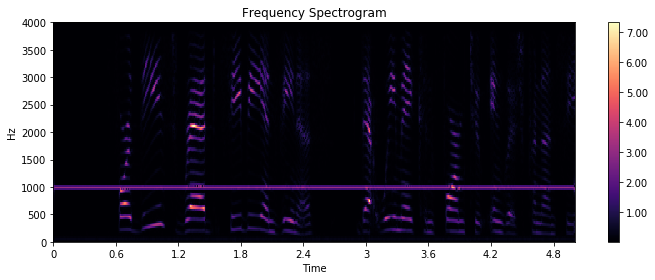

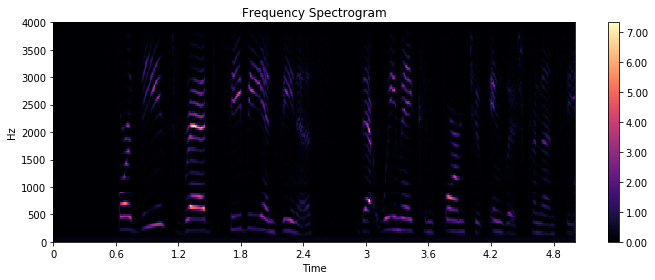

In [4]:
y_voice = voice_ds.load([0])[0]
y_tone = generate_tone(sr, duration, np.array([1000]), np.array([0.05]))[0]

y = y_voice + y_tone
play_audio(y, sr)
spectrogram = audio_to_spectrogram([y], sr)[0]

show_spectrogram(np.abs(spectrogram), sr)
plt.show()
play_audio(spectrogram_to_audio([spectrogram], sr)[0], sr)

spectrogram[30:34, :] = 0

show_spectrogram(np.abs(spectrogram), sr)
plt.show()
play_audio(spectrogram_to_audio([spectrogram], sr)[0], sr)


# Base Method

Make a neural network to just take out the tone

In [10]:
num_sources = 2

def generate_sources(batch_size, pbar=None):
    s1 = voice_ds.load_next(batch_size, pbar=pbar)
    s2 = generate_tone(sr, duration, np.linspace(750, 2500, batch_size), 0.05*np.ones(batch_size))
#     s2 = noise_ds.load_next(batch_size, pbar=pbar)
#     s3 = generate_tone(sr, duration, np.linspace(750, 2500, batch_size), 0.05*np.ones(batch_size))
    ss = (s1, s2,)
    return np.stack(ss, axis=0)

def generate_nn_io(sources=None, batch_size=None, pbar=None):
    if sources is None:
        sources = generate_sources(batch_size, pbar=pbar)
    
    X_batch = sources.sum(axis=0) # input is the mixture
    X_batch = complex_to_channels(audio_to_spectrogram(X_batch, sr))
    
    Y_batch = []
    for source_idx in range(num_sources-1): # output is all but the noise
        source = sources[source_idx]
        source = complex_to_channels(audio_to_spectrogram(source, sr))
        Y_batch.append(source)
        
    Y_batch = np.concatenate(Y_batch, axis=-3)
    return X_batch, Y_batch
    

mse = nn.MSELoss()

def loss_function(Y_batch_pred, Y_batch):
    # normal MSE loss for now
    return mse(Y_batch_pred, Y_batch)

In [11]:
# create test set
voice_ds.reset_next()
test_set_size = 10

test_sources = generate_sources(test_set_size, pbar=tqdm())
X_test, Y_test = generate_nn_io(test_sources)

print(X_test.shape)
print(Y_test.shape)

(10, 2, 129, 626)
(10, 2, 129, 626)


In [12]:
def show_test_performance(model_g, X_test, Y_test):
    with torch.no_grad():
        Y_test_pred = model_g.forward(to_torch(X_test))
        print('Test Loss: ', loss_function(Y_test_pred, to_torch(Y_test)).item())
    

def show_test_example(model_g, X_test, Y_test, show_idx=0):
    X_test = X_test[show_idx:show_idx+1]
    Y_test = Y_test[show_idx:show_idx+1]
    with torch.no_grad():
        Y_test_pred = to_np(model_g.forward(to_torch(X_test)))
    
    X_test = channels_to_complex(X_test)
    Y_test = channels_to_complex(Y_test)
    Y_test_pred = channels_to_complex(Y_test_pred)
    
    print("Input: ")
    show_complete_spectrogram(X_test[0], sr)
    plt.show()
    play_audio(spectrogram_to_audio(X_test, sr)[0], sr)

    # show_complete_spectrogram(Y_test[0], sr)
    # plt.show()
    # play_audio(spectrogram_to_audio(Y_test, sr)[0], sr)

    print("Output: ")
    show_complete_spectrogram(Y_test_pred[0], sr)
    plt.show()
    play_audio(spectrogram_to_audio(Y_test_pred, sr)[0], sr)

In [13]:
import gc
gc.collect()

19232

Test Loss:  0.2965957224369049
Input: 


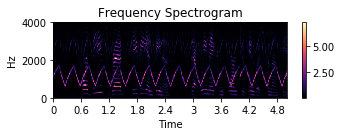

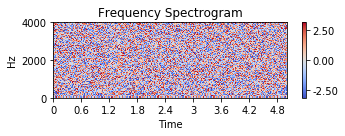

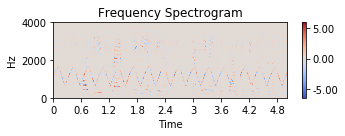

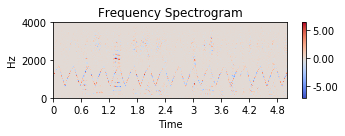

Output: 


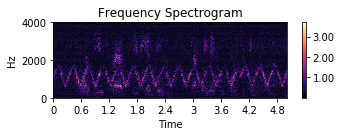

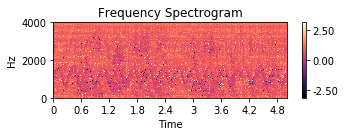

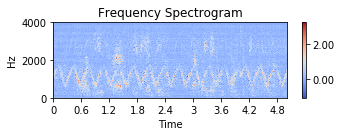

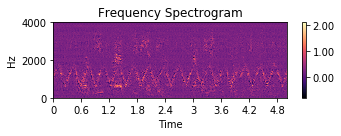

In [14]:
show_test_performance(model_g, X_test, Y_test)
show_test_example(model_g, X_test, Y_test, show_idx=0)

In [26]:
%%time
crit = nn.MSELoss()
losses = []
batch_size = 10

batch_pbar = tqdm(range(300), desc='Batches')
load_tqdm = tqdm(desc='Loading batch')

for batch_idx in batch_pbar:
    load_tqdm.reset(total=batch_size)
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size, pbar=load_tqdm)
    X_batch, Y_batch = to_torch(X_batch, Y_batch)

    model_g.opt.zero_grad()
    Y_batch_pred = model_g.forward(X_batch)
    loss = crit(Y_batch_pred, Y_batch)
    loss.backward()
    model_g.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(loss)
    
plt.plot(np.arange(len(losses)), losses)

0.065484926


KeyboardInterrupt: 

Test Loss:  0.042723968625068665
Input: 


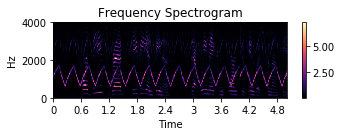

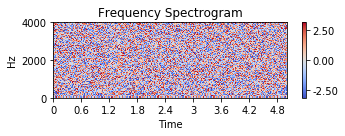

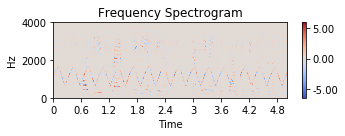

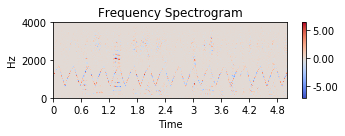

Output: 


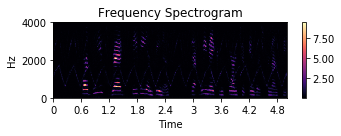

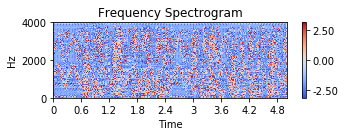

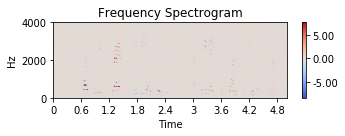

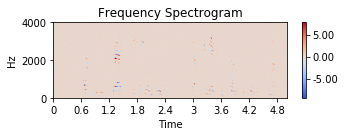

In [16]:
show_test_performance(model_g, X_test, Y_test)
show_test_example(model_g, X_test, Y_test, show_idx=0)

Input: 


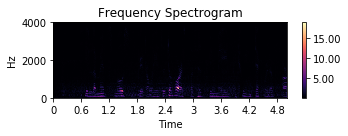

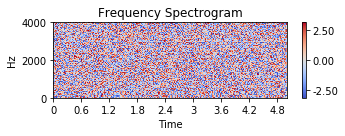

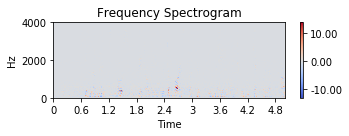

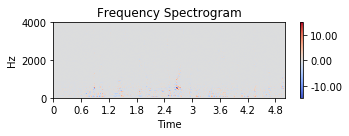

Output: 


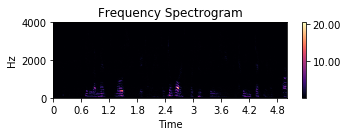

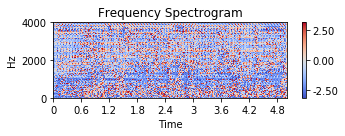

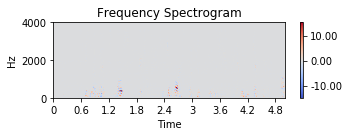

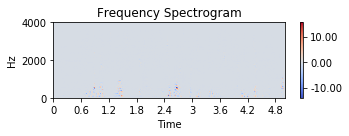

In [23]:
show_test_example(model_g, X_test, Y_test, show_idx=7)

In [38]:
torch.save(model_g, f'models/ftnn_naive_med_epochs{300}.pth')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FTNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type NeuralTransform. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Our Method

Generator-Discriminator setup (without GAN)

In [ ]:
mse_crit = nn.MSELoss()
bce_crit = nn.BCELoss()

def loss_func(X_batch, Y_batch, Y_batch_pred, model_d):
    Yp_batch = X_batch - Y_batch
    Yp_batch_pred = X_batch - Y_batch_pred
    
    d_Y_batch_pred = model_d.forward(Y_batch_pred)
    d_Yp_batch_pred = model_d.forward(Yp_batch_pred)
    
    loss1 = mse_crit(Y_batch_pred, Y_batch)
#     loss2 = mse_crit(Yp_batch, Yp_batch_pred) # EXACT same the previous
    
    loss3 = bce_crit(d_Y_batch_pred, torch.ones_like(d_Y_batch_pred))
    loss4 = bce_crit(d_Yp_batch_pred, torch.zeros_like(d_Yp_batch_pred))
    
    total_loss = loss1+loss3+loss4
    
    return total_loss

### Training Discriminator

In [98]:
# create test set
voice_ds.reset_next()
test_set_size = 10

X_test, Y_test = generate_nn_io(batch_size=test_set_size, pbar=tqdm())

print(X_test.shape)
print(Y_test.shape)

(10, 2, 129, 626)
(10, 2, 129, 626)


In [114]:
bce = nn.BCELoss()

with torch.no_grad():
    Y_test_pred = model_g.forward(to_torch(X_test))

    fake_out = model_d.forward(Y_test_pred)
    real_out = model_d.forward(to_torch(Y_test))

    test_loss = (bce(fake_out, torch.zeros_like(fake_out)) + bce(real_out, torch.ones_like(fake_out))).item()
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  1.401592493057251
Accuracy:  0.5


In [105]:
%%time
bce = nn.BCELoss()
losses = []
batch_size = 10
for epoch in tqdm(range(50)):
    X_batch, Y_batch = generate_nn_io(batch_size=batch_size, pbar=tqdm())
    X_batch, Y_batch = to_torch(X_batch, Y_batch)
    
    with torch.no_grad():
        model_g.eval()
        Y_batch_pred = model_g(X_test)
    
    model_d.train()
    model_d.opt.zero_grad()
    real_out = model_d(Y_batch)
    fake_out = model_d(Y_batch_pred)
    loss = bce(real_out, torch.ones_like(real_out)) + bce(fake_out, torch.zeros_like(fake_out))
    loss.backward()
    model_d.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(loss)
    
plt.plot(np.arange(len(losses)), losses)

NameError: name 'model_d' is not defined

In [64]:
Y_test_pred = model_d.forward(torch.from_numpy(X_test).to(device, dtype)).detach().cpu().numpy()
print('Accuracy: ', ((Y_test_pred>0.5) == (Y_test>0.5)).sum()/len(Y_test))

Accuracy:  1.0


In [66]:
torch.save(model_d, 'models/disc_model.pth')